In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.stats import chi2_contingency, ks_2samp
from typing import List, Tuple, Dict
from concurrent.futures import ThreadPoolExecutor

In [2]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
df.head(5)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB
None


In [4]:
# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000000   
mean   4.974577e+06                  1.461200           4159.677034   
std    2.293890e+06                  1.743846           1421.399078   
min    1.000324e+06                  0.000000             46.783973   
25%    2.977661e+06                  0.000000           3154.235371   
50%    4.989502e+06                  1.000000           4052.377228   
75%    6.967210e+06                  2.000000           5052.898103   
max    8.999789e+06                  5.000000          10750.677810   

       total_debt_outstanding         income  years_employed    fico_score  \
count            10000.000000   10000.000000    10000.000000  10000.000000   
mean              8718.916797   70039.901401        4.552800    637.557700   
std               6627.164762   20072.214143        1.566862     60.657906   
min                 31.652732

FICOQuantizer is  a class for binning FICO scores into discrete buckets with various optimization methods. Supports equal width, equal frequency, and information value-based optimization approaches.

In [15]:
class FICOQuantizer:
    def __init__(
        self,
        df: pd.DataFrame,
        fico_col: str = "fico_score",
        default_col: str = "default",
    ):
        self.df = df
        self.fico_col = fico_col
        self.default_col = default_col
        self.last_boundaries = None

    def equal_width_buckets(self, n_buckets: int) -> List[int]:
        """Create buckets of equal width across the FICO score range."""
        min_score = self.df[self.fico_col].min()
        max_score = self.df[self.fico_col].max()
        return list(np.linspace(min_score, max_score, n_buckets + 1).astype(int))

    def equal_frequency_buckets(self, n_buckets: int) -> List[int]:
        """Create buckets with approximately equal number of observations."""
        quantiles = np.linspace(0, 100, n_buckets + 1)
        return list(np.percentile(self.df[self.fico_col], quantiles).astype(int))

    def optimize_information_value(
        self, n_buckets: int, iterations: int = 10) -> List[int]:
        # Start with equal frequency buckets
        boundaries = self.equal_frequency_buckets(n_buckets)
        best_iv = self._calculate_iv(boundaries)
        best_boundaries = boundaries.copy()

        # Enhanced optimization with varying step sizes
        step_sizes = [20, 10, 5]  # Multiple step sizes for finer optimization

        # Iterate through step sizes, iterations, and boundary indices
        for step in step_sizes:
            for _ in range(iterations):
                for i in range(1, len(boundaries) - 1):
                    for shift in [-step, step]:
                        new_boundary = boundaries[i] + shift
                        if boundaries[i - 1] < new_boundary < boundaries[i + 1]:
                            # If the shifted boundary is valid, update best_iv and best_boundaries
                            current_iv = self._calculate_iv(
                                boundaries[:i] + [new_boundary] + boundaries[i + 1 :]
                            )
                            if current_iv > best_iv:
                                best_iv, best_boundaries = (
                                    current_iv,
                                    boundaries[:i]
                                    + [new_boundary]
                                    + boundaries[i + 1 :],
                                )

        return (
            best_boundaries  # Return the boundaries with the highest Information Value
        )

    def _calculate_iv(self, boundaries: List[int]) -> float:
        """Calculate Information Value with improved handling of edge cases."""
        df = self.df.copy()
        df["bucket"] = pd.cut(df[self.fico_col], boundaries, labels=False)

        grouped = df.groupby("bucket").agg({self.default_col: ["count", "sum"]})

        good = grouped[self.default_col]["count"] - grouped[self.default_col]["sum"]
        bad = grouped[self.default_col]["sum"]

        good_pct = good / good.sum()
        bad_pct = bad / bad.sum()

        # Enhanced handling of zero cases
        min_pct = 0.0001
        good_pct = good_pct.clip(lower=min_pct)
        bad_pct = bad_pct.clip(lower=min_pct)

        woe = np.log(good_pct / bad_pct)
        iv = ((good_pct - bad_pct) * woe).sum()

        return iv

    def validate_buckets(self, boundaries: List[int]) -> Dict:
        """
        Comprehensive validation of bucket effectiveness.
        """
        df = self.df.copy()
        df["bucket"] = pd.cut(df[self.fico_col], boundaries, labels=False)

        # Calculate metrics
        metrics = {}

        # Population stability
        pop_dist = df["bucket"].value_counts(normalize=True)
        metrics["min_bucket_pct"] = pop_dist.min() * 100

        # Monotonicity check
        default_rates = df.groupby("bucket")[self.default_col].mean()
        metrics["is_monotonic"] = default_rates.is_monotonic_increasing

        # Discriminatory power
        metrics["ks_statistic"] = self._calculate_ks_statistic(df)

        # Gini coefficient
        metrics["gini"] = self._calculate_gini(df)

        # Chi-square test for independence
        contingency_table = pd.crosstab(df["bucket"], df[self.default_col])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        metrics["chi2_p_value"] = p_value

        return metrics

    def _calculate_ks_statistic(self, df: pd.DataFrame) -> float:
        """Calculate Kolmogorov-Smirnov statistic for bucket effectiveness."""
        good_scores = df[df[self.default_col] == 0][self.fico_col]
        bad_scores = df[df[self.default_col] == 1][self.fico_col]
        ks_stat, _ = ks_2samp(good_scores, bad_scores)
        return ks_stat

    def _calculate_gini(self, df: pd.DataFrame) -> float:
        """Calculate Gini coefficient for discriminatory power."""
        auc = roc_auc_score(df[self.default_col], -df[self.fico_col])
        return 2 * auc - 1

    def plot_bucket_analysis(self, boundaries: List[int], figsize=(15, 10)):
        """
        Create comprehensive visualizations of bucket performance.
        """
        df = self.df.copy()
        df["bucket"] = pd.cut(df[self.fico_col], boundaries, labels=False)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Population distribution
        sns.histplot(data=df, x="bucket", ax=ax1)
        ax1.set_title("Population Distribution by Bucket")
        ax1.set_xlabel("Bucket")
        ax1.set_ylabel("Count")

        # Plot 2: Default rates
        default_rates = df.groupby("bucket")[self.default_col].mean()
        default_rates.plot(kind="bar", ax=ax2)
        ax2.set_title("Default Rate by Bucket")
        ax2.set_xlabel("Bucket")
        ax2.set_ylabel("Default Rate")

        # Plot 3: FICO score distribution by bucket
        sns.boxplot(data=df, x="bucket", y=self.fico_col, ax=ax3)
        ax3.set_title("FICO Score Distribution by Bucket")
        ax3.set_xlabel("Bucket")
        ax3.set_ylabel("FICO Score")

        # Plot 4: ROC curve
        from sklearn.metrics import roc_curve

        fpr, tpr, _ = roc_curve(df[self.default_col], -df[self.fico_col])
        ax4.plot(fpr, tpr)
        ax4.plot([0, 1], [0, 1], "k--")
        ax4.set_title("ROC Curve")
        ax4.set_xlabel("False Positive Rate")
        ax4.set_ylabel("True Positive Rate")

        plt.tight_layout()
        return fig

    def get_optimal_buckets( # Corrected indentation
        self, n_buckets: int, method: str = "information_value") -> Dict:
        """
        Get optimal bucket boundaries using the specified method and return comprehensive analysis.
        """
        if method == "equal_width":
            boundaries = self.equal_width_buckets(n_buckets)
        elif method == "equal_frequency":
            boundaries = self.equal_frequency_buckets(n_buckets)
        else:
            boundaries = self.optimize_information_value(n_buckets)

        self.last_boundaries = boundaries
        analysis = self.analyze_buckets(boundaries)
        validation = self.validate_buckets(boundaries)

        return {
            "boundaries": boundaries,
            "analysis": analysis,
            "validation": validation,
        }

    def analyze_buckets(self, boundaries: List[int]) -> pd.DataFrame:
        """Enhanced bucket analysis with additional metrics."""
        df = self.df.copy()
        df["bucket"] = pd.cut(df[self.fico_col], boundaries, labels=False)

        analysis = (
            df.groupby("bucket")
            .agg(
                {
                    self.fico_col: ["count", "mean", "std", "min", "max"],
                    self.default_col: ["mean", "sum"],
                }
            )
            .round(4)
        )

        analysis.columns = [
            "count",
            "avg_fico",
            "std_fico",
            "min_fico",
            "max_fico",
            "default_rate",
            "default_count",
        ]

        analysis["population_pct"] = (analysis["count"] / len(df) * 100).round(2)
        analysis["bucket_range"] = [
            f"{boundaries[i]}-{boundaries[i+1]}" for i in range(len(boundaries) - 1)
        ]
        analysis["woe"] = self._calculate_woe_by_bucket(df)

        return analysis

    def _calculate_woe_by_bucket(self, df: pd.DataFrame) -> pd.Series:
        """Calculate Weight of Evidence for each bucket."""
        grouped = df.groupby("bucket").agg({self.default_col: ["count", "sum"]})

        good = grouped[self.default_col]["count"] - grouped[self.default_col]["sum"]
        bad = grouped[self.default_col]["sum"]

        good_pct = good / good.sum()
        bad_pct = bad / bad.sum()

        # Handle zero cases
        min_pct = 0.0001
        good_pct = good_pct.clip(lower=min_pct)
        bad_pct = bad_pct.clip(lower=min_pct)

        return np.log(good_pct / bad_pct)

The BucketingStrategyOptimizer provides advanced optimization capabilities for finding the best FICO score bucketing strategy. It evaluates different bucketing methods across various metrics and provides recommendations based on comprehensive analysis.

In [16]:
class BucketingStrategyOptimizer:
    def __init__(self, quantizer, monotonicity_threshold: float = 0.8):
        self.quantizer = quantizer
        self.monotonicity_threshold = monotonicity_threshold

    def check_monotonicity(self, default_rates: pd.Series) -> Tuple[bool, float]:
        """
        Check monotonicity of default rates with flexible threshold.
        """
        differences = np.diff(default_rates)
        monotonic_pairs = (differences >= -0.0001).sum()  # Small tolerance for floating point
        monotonicity_ratio = monotonic_pairs / len(differences)
        return monotonicity_ratio >= self.monotonicity_threshold, monotonicity_ratio

    def _calculate_default_rate_separation(self, analysis: pd.DataFrame) -> float:
        """
        Calculate average difference in default rates between adjacent buckets.
        """
        default_rates = analysis['default_rate']
        return np.mean(np.abs(np.diff(default_rates)))

    def _calculate_population_stability(self, analysis: pd.DataFrame) -> float:
        """
        Calculate population stability index.
        """
        expected_pct = 100 / len(analysis)
        actual_pct = analysis['population_pct']
        return np.mean(np.abs(actual_pct - expected_pct))

    def plot_strategy_comparison(self, comparison_df: pd.DataFrame, figsize=(15, 10)):
        """
        Create visualization of strategy comparison results.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: KS Statistic by number of buckets and method
        sns.lineplot(data=comparison_df, x='n_buckets', y='ks_statistic',
                    hue='method', marker='o', ax=ax1)
        ax1.set_title('KS Statistic by Strategy')

        # Plot 2: Population stability
        sns.lineplot(data=comparison_df, x='n_buckets', y='population_stability',
                    hue='method', marker='o', ax=ax2)
        ax2.set_title('Population Stability by Strategy')

        # Plot 3: Default rate separation
        sns.lineplot(data=comparison_df, x='n_buckets', y='avg_default_rate_diff',
                    hue='method', marker='o', ax=ax3)
        ax3.set_title('Average Default Rate Separation')

        # Plot 4: Monotonicity ratio
        sns.lineplot(data=comparison_df, x='n_buckets', y='monotonicity_ratio',
                    hue='method', marker='o', ax=ax4)
        ax4.set_title('Monotonicity Ratio by Strategy')

        plt.tight_layout()
        return fig

    def compare_strategies(self, bucket_ranges: List[int] = [3, 4, 5, 6, 7, 8, 9, 10]) -> pd.DataFrame:
        """
        Compare different bucketing strategies with enhanced metrics.
        """
        results = []
        methods = ['equal_width', 'equal_frequency', 'information_value']

        for n_buckets in bucket_ranges:
            for method in methods:
                result = self.quantizer.get_optimal_buckets(n_buckets, method)
                default_rates = result['analysis']['default_rate']

                is_monotonic, monotonicity_ratio = self.check_monotonicity(default_rates)

                metrics = {
                    'n_buckets': n_buckets,
                    'method': method,
                    'min_population_pct': result['validation']['min_bucket_pct'],
                    'is_monotonic': is_monotonic,
                    'monotonicity_ratio': monotonicity_ratio,
                    'ks_statistic': result['validation']['ks_statistic'],
                    'gini': result['validation']['gini'],
                    'chi2_p_value': result['validation']['chi2_p_value'],
                    'default_rates': list(default_rates)
                }

                # Calculate additional metrics
                analysis = result['analysis']
                metrics['avg_default_rate_diff'] = self._calculate_default_rate_separation(analysis)
                metrics['population_stability'] = self._calculate_population_stability(analysis)

                results.append(metrics)

        return pd.DataFrame(results)

    def get_recommended_strategy(self, comparison_df: pd.DataFrame) -> Dict:
        """
        Get recommended strategy with more flexible criteria.
        """
        if len(comparison_df) == 0:
            return {"error": "No strategies found"}

        # Score each strategy based on multiple criteria
        scores = pd.DataFrame(index=comparison_df.index)

        # Normalize and score each metric
        metrics = ['ks_statistic', 'gini', 'avg_default_rate_diff', 'monotonicity_ratio']
        for metric in metrics:
            scores[metric] = (comparison_df[metric] - comparison_df[metric].min()) / \
                           (comparison_df[metric].max() - comparison_df[metric].min())

        # Population stability (lower is better)
        scores['population_stability'] = 1 - (comparison_df['population_stability'] - comparison_df['population_stability'].min()) / \
                                           (comparison_df['population_stability'].max() - comparison_df['population_stability'].min())

        # Calculate overall score
        scores['total_score'] = scores.mean(axis=1)

        # Get best strategy
        best_idx = scores['total_score'].idxmax()
        best_strategy = comparison_df.loc[best_idx]

        return {
            'recommended_method': best_strategy['method'],
            'recommended_n_buckets': int(best_strategy['n_buckets']),
            'metrics': {
                'ks_statistic': best_strategy['ks_statistic'],
                'gini': best_strategy['gini'],
                'population_stability': best_strategy['population_stability'],
                'avg_default_rate_diff': best_strategy['avg_default_rate_diff'],
                'monotonicity_ratio': best_strategy['monotonicity_ratio']
            },
            'default_rates': best_strategy['default_rates']
        }

In [17]:
# Initialize quantizer and optimizer
quantizer = FICOQuantizer(df)
optimizer = BucketingStrategyOptimizer(quantizer)

In [26]:
# Adjust bucket ranges
bucket_ranges = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Compare strategies
print("Comparing strategies...")
comparison_df = optimizer.compare_strategies(bucket_ranges=bucket_ranges)

Comparing strategies...


In [27]:
# Get recommendation
recommendation = optimizer.get_recommended_strategy(comparison_df)

In [28]:
# Check for error before printing results
if 'error' in recommendation:
    print(f"\nError: {recommendation['error']}")
else:
    print("\nRecommended Strategy:")
    print(f"Method: {recommendation['recommended_method']}")
    print(f"Number of buckets: {recommendation['recommended_n_buckets']}")


Recommended Strategy:
Method: equal_width
Number of buckets: 10


In [29]:
# Get optimal buckets using recommended strategy
optimal_results = quantizer.get_optimal_buckets(
    n_buckets=recommendation['recommended_n_buckets'],
    method=recommendation['recommended_method']
)

In [30]:
# Print detailed analysis
print("\nDetailed Bucket Analysis:")
print(optimal_results['analysis'])


Detailed Bucket Analysis:
        count  avg_fico  std_fico  min_fico  max_fico  default_rate  \
bucket                                                                
0.0        11  437.3636   13.9447       409       450        0.6364   
1.0       117  480.5299   11.8610       455       496        0.7350   
2.0       439  522.5991   12.3486       497       540        0.5103   
3.0      1323  565.9856   12.2596       541       584        0.3537   
4.0      2529  608.5737   12.9307       585       629        0.2048   
5.0      2807  651.0823   12.6175       630       673        0.1325   
6.0      1856  693.1880   12.4178       674       717        0.0787   
7.0       732  734.4495   11.9889       718       761        0.0355   
8.0       161  778.9503   11.6280       762       805        0.0186   
9.0        24  819.1667   11.2392       806       850        0.0417   

        default_count  population_pct bucket_range       woe  
bucket                                                   

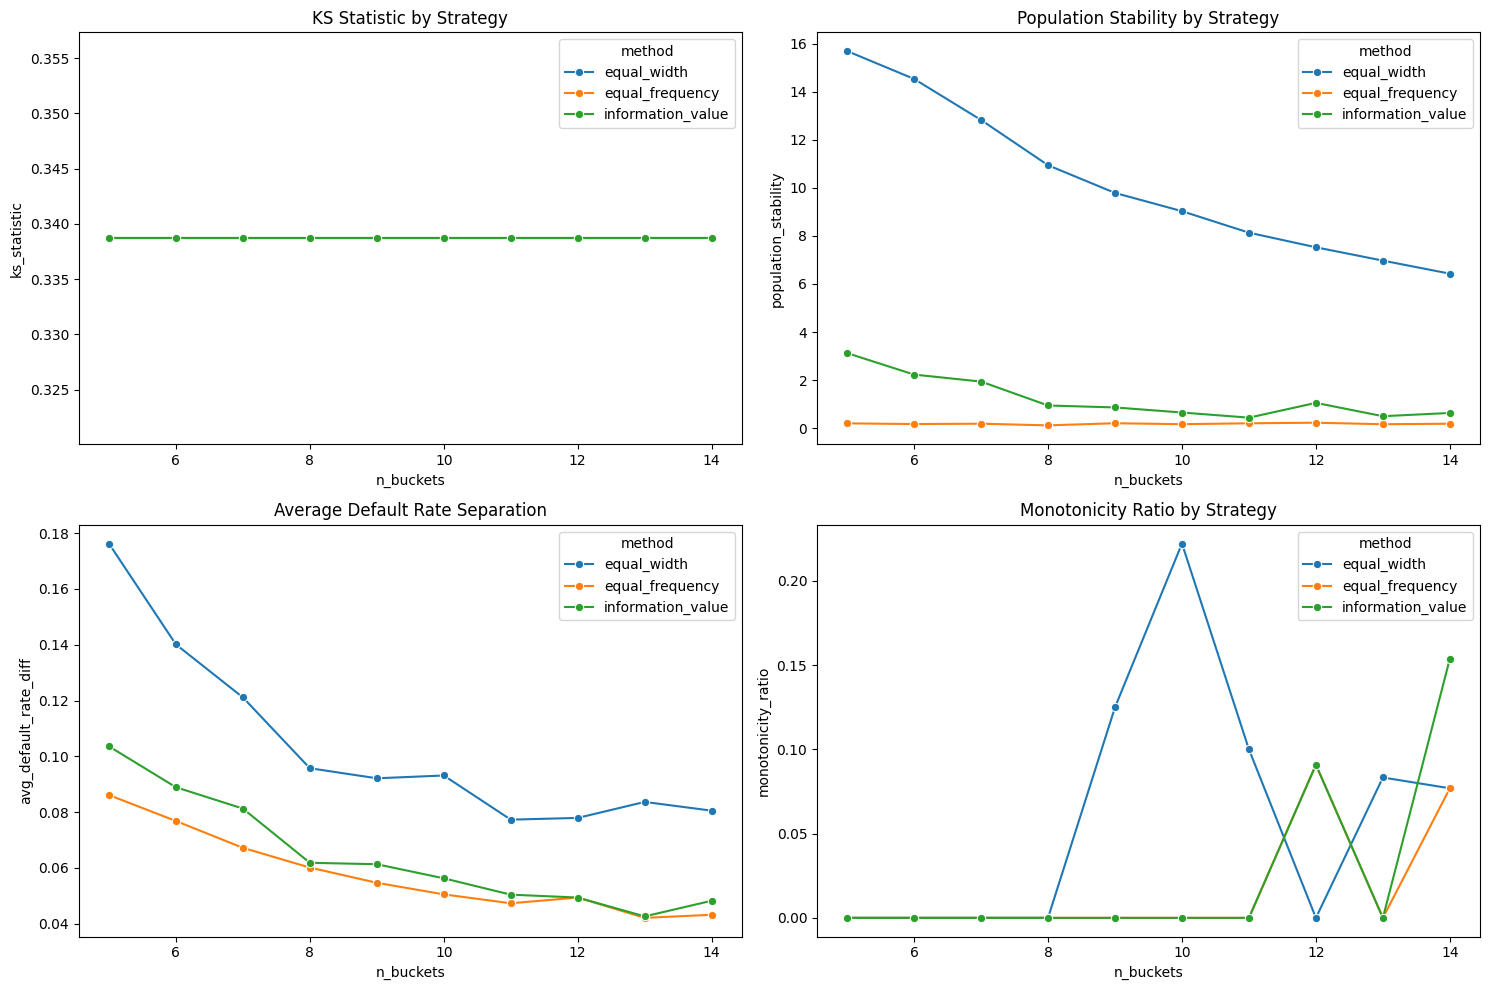

In [31]:
# Create comparison visualization
fig1 = optimizer.plot_strategy_comparison(comparison_df)
plt.show()

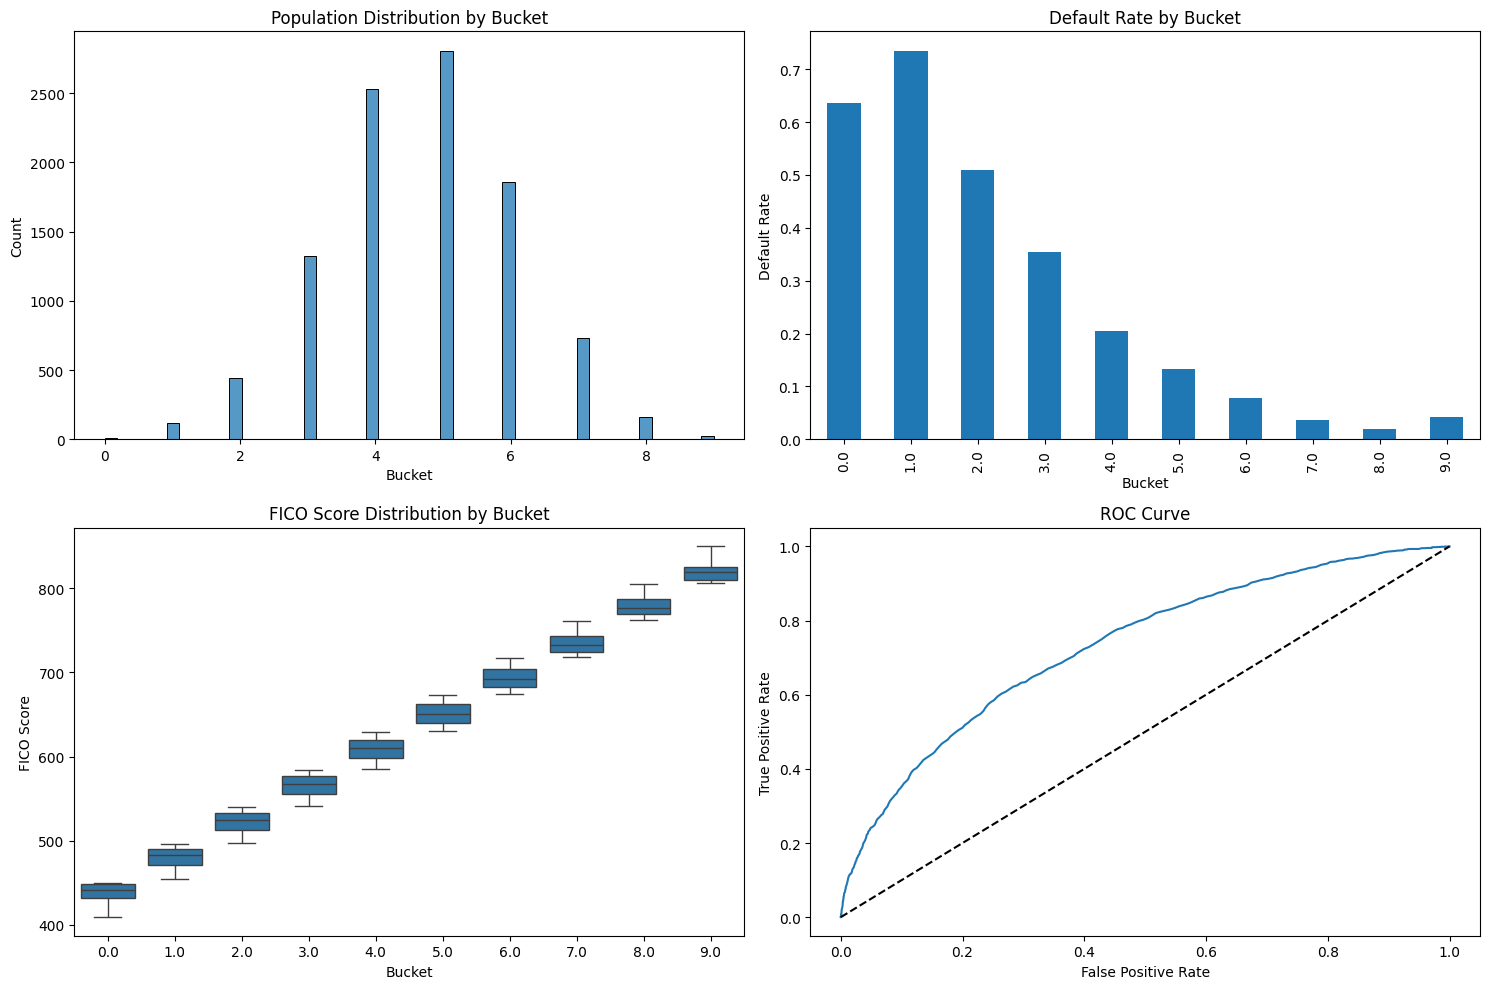

In [32]:
# Create bucket analysis visualization
fig2 = quantizer.plot_bucket_analysis(optimal_results['boundaries'])
plt.show()